# Figures of Merit - notes

Sean adapted this from the report-copy1.ipynb notebook from Felipe & Rebekah.

This workbook will give you important figures of merit for a given xy test.

The only variables that will need to be updated:

### System parameters,  all come from Report-Copy1.ipynb
- pix2mm - the pixels-mm conversion factor
- xc, yc - the x and y coordinates of the center of the positioner in mm's 
- rPositioner - the radius of the positioner in mm's
- hardstopAngle - the angle in degrees of the hardstop angle

### xy test parameters
- dateStart - The  datetime when you started your test
- label - The label of the test you are running - can be found as the name of the .ini file (ex. for xy_60.ini, label = "xy_60"
- dateEnd - Left as placeholder for the last date to be queried by the database

# Useful imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/DESI-QA/")
sys.path.append("/home/msdos/DESI-QA/output/figures/")
import find_center as fc
from spotfinder import spotfinder
from xylib import calc_movetables as cm

plt.rcParams.update({'figure.dpi':120})

ModuleNotFoundError: No module named 'spotfinder'

# Defining functions to be used later

In [294]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)
        
        
def get_dbxy(db,  datemin, datemax, label):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy


def plot_circle(xc, yc, R, kwargs={},axs = None):
    _th = np.linspace(0, 2*np.pi)
    if axs !=None:
        axs.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='green', ls='--', lw=0.6)
    else:
        plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='green', ls='--', lw=0.6)
    return 


def plot_xy(label, datemin, datemax, fig,ax,movefn, title='', show=True,save=False,pathname=None):
    dbxy = get_dbxy(db, datemin, datemax,label=label)
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    ax.scatter('xpos', 'ypos', data=dbxy, c='black', marker ='+', s=30)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    ax.scatter('xpos', 'ypos', data=xytgt, facecolors='none',edgecolors='r', s=10, c='red', lw=0.5,label='target')
    ax.set_xlabel('xpos (mm)')
    ax.set_ylabel('ypos (mm)')
    ax.set_title(title, fontsize=8)
#     ax.set_xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if save:
        plt.savefig(pathname,dpi=180)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_formatting(num=1):
    fig,ax = plt.subplots(1,int(num),figsize=[6,6*int(num)])
    plot_circle(0,0, rPositioner)
    plt.grid(lw=0.6, ls='--')
    plt.plot(-np.linspace(0, rPositioner* np.cos(hardstopAngle)), np.linspace(0, rPositioner* np.sin(hardstopAngle)), lw=1 , c='g', label='hardstop'  )

    ax.set_xlim(-7,7)
    ax.set_ylim(-7,7)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    return fig,ax

def get_moveDirection(label,ABS=False):
    '''
    Function to take xy positions from a movetable and 
    return the theta and phi moves in separate arrays
    
    Here, CW is defined as positive and CCW is defined as negative
    '''

    df = pd.read_csv("/home/msdos/DESI-QA/movetables/"+label+".txt",sep=" ",names=["x","y"])
    
    theta_arr = np.array([0]) # set initial move direction to 0, since it can vary based on previous position - possible place to revise in the future, if necessary
    phi_arr = np.array([0])

    for j in range(len(df)-1):
        current = (j+1)
        old = j

        x_old,y_old = (df["x"][old],df["y"][old])
        x_current,y_current = (df["x"][current],df["y"][current])

        row = cm(hardstopAngle,R1,R2,x_old,y_old,x_current,y_current)

        if len(row)==1:
            if row[0][1]=='theta':
                phi_arr = np.append(phi_arr,0)
                if row[0][0]=="cw":
                    theta_arr = np.append(theta_arr,row[0][2])
                else:
                    theta_arr = np.append(theta_arr,-row[0][2])
            elif row[0][1]=='phi':
                theta_arr = np.append(theta_arr,0)
                if row[0][0]=="cw":
                    phi_arr = np.append(phi_arr,row[0][2])
                else:
                    phi_arr = np.append(phi_arr,-row[0][2])
            else:
                print("Rows from movetable are incompatible with storage settings - please check movetable!")
                print("Row "+str(j))
                break
        elif len(row)==2:

            if row[0][0]=="cw":
                theta_arr = np.append(theta_arr,row[0][2])
            else:
                theta_arr = np.append(theta_arr,-row[0][2])

            if row[1][0]=="cw":
                phi_arr = np.append(phi_arr,row[1][2])
            else:
                phi_arr = np.append(phi_arr,-row[1][2])
        else:
            print("Rows from movetable are incompatible with storage settings - please check movetable!")
            print("Row "+str(j))
            break
    if ABS:
        theta_arr = np.abs(theta_arr)
        phi_arr = np.abs(phi_arr)
    return theta_arr,phi_arr

# Defining the parameters of your xytest
# Defining paths, pixels-mm conversion factor, and center of positioner

In [482]:
# All of these values can be found in Report-Copy1.ipynb - maybe figure a way to pass these values as a dictionary or something?
pix2mm = 0.03536752443853155 # last updated may 22
xc, yc = [69.88742, 32.47921]
R1 = 2.9531164 
R2 = 3.0736282
rPositioner = R1+R2
hardstopAngle = 163.23775

In [483]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

# dateStartArr = np.array(['2023-05-30 11:48:00','2023-06-01 18:13:00','2023-06-01 19:03:00','2023-05-24 16:42:00'],dtype='datetime64')
# dateEndArr = dateStartArr+np.timedelta64(2, 'm')
# labelArr = np.array(['zig_','zig_','',''])
# labelArr = np.array(['zig','zig_flipx','zig_flipy','zig_flipxy','zag','zag_flipx','zag_flipy','zag_flipxy'])

iteration = 2

# Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
# dateStart =str(dateStartArr[iteration]) # This is the  time when you started your test
# label = 'xy_60'+labelArr[iteration] # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future
# dateEnd = str(dateEndArr[iteration]) # Left as placeholder, you will have to update this occasionally

dateStart ='2023-06-14 16:42:00' # This is the  time when you started your test
label = 'xy_60' # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future
dateEnd = np.datetime64(dateStart)+np.timedelta64(2,'m') # Left as placeholder, you will have to update this occasionally

db.tail()

get_timecol(db)

m2 = query_time(db, datemin=dateStart,datemax=dateEnd)
m2 = (m2) & ( db['label'].str.endswith(label) )
get_dbxy(db, datemin=dateStart, datemax=dateEnd, label=label)

xytgt = pd.read_csv("../movetables/"+label+".txt", sep=" ", header=None)
# xytgt = pd.read_csv("../movetables/"+"xy_60_zig_flipxy"+".txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

['2023-06-14T16:42:53.000000000']
(60, 2)


## General figure, showing positional offsets

In [484]:
# len(db[m2])

['2023-06-14T16:42:53.000000000']
(60, 2)


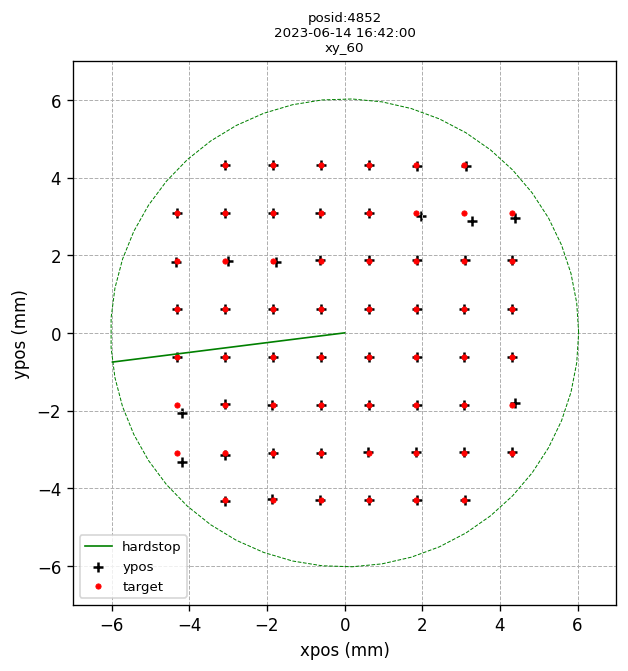

In [485]:
fSig, ax = plot_formatting()
dbxy, xytgt = plot_xy(label, dateStart, dateEnd, movefn=label+".txt",title='posid:4852\n'+dateStart+"\n"+label,fig=fig,ax=ax,save=True,pathname="/home/msdos/DESI-QA/output/figures/ParameterTest/Positional_"+label+"_"+dateStart+".jpg")
# dbxy, xytgt = plot_xy(label, dateStart, dateEnd, movefn="xy_60_zig_flipxy"+".txt",title='posid:4852\n'+dateStart+"\n"+label,fig=fig,ax=ax)

# Quiver plot, showing positional offsets

Max arrow length = 284.4 um
Mean arrow length = 33.3 um
Median arrow length = 8.9 um


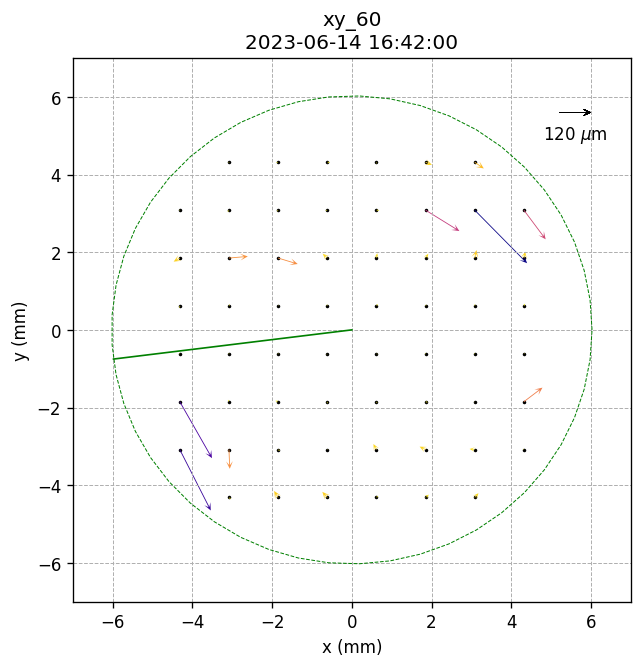

In [486]:
# Creating plot
fig, ax = plot_formatting()

end = 60

xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt[0:end])
v = 1e3 * (ypos - yt[0:end])
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=120
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt[0:end], yt[0:end], u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_title(label+"\n"+dateStart)

# ax.set_ylim([-12,12])
# ax.set_xlim([-12,12])

save=True

if save:
    plt.savefig("/home/msdos/DESI-QA/output/figures/ParameterTest/Quiver_"+label+"_"+dateStart+".jpg",dpi=180)

print(f'Mean arrow length = {np.mean(dr):.1f} um')
print(f'Median arrow length = {np.median(dr):.1f} um')

# Histogram of residual values

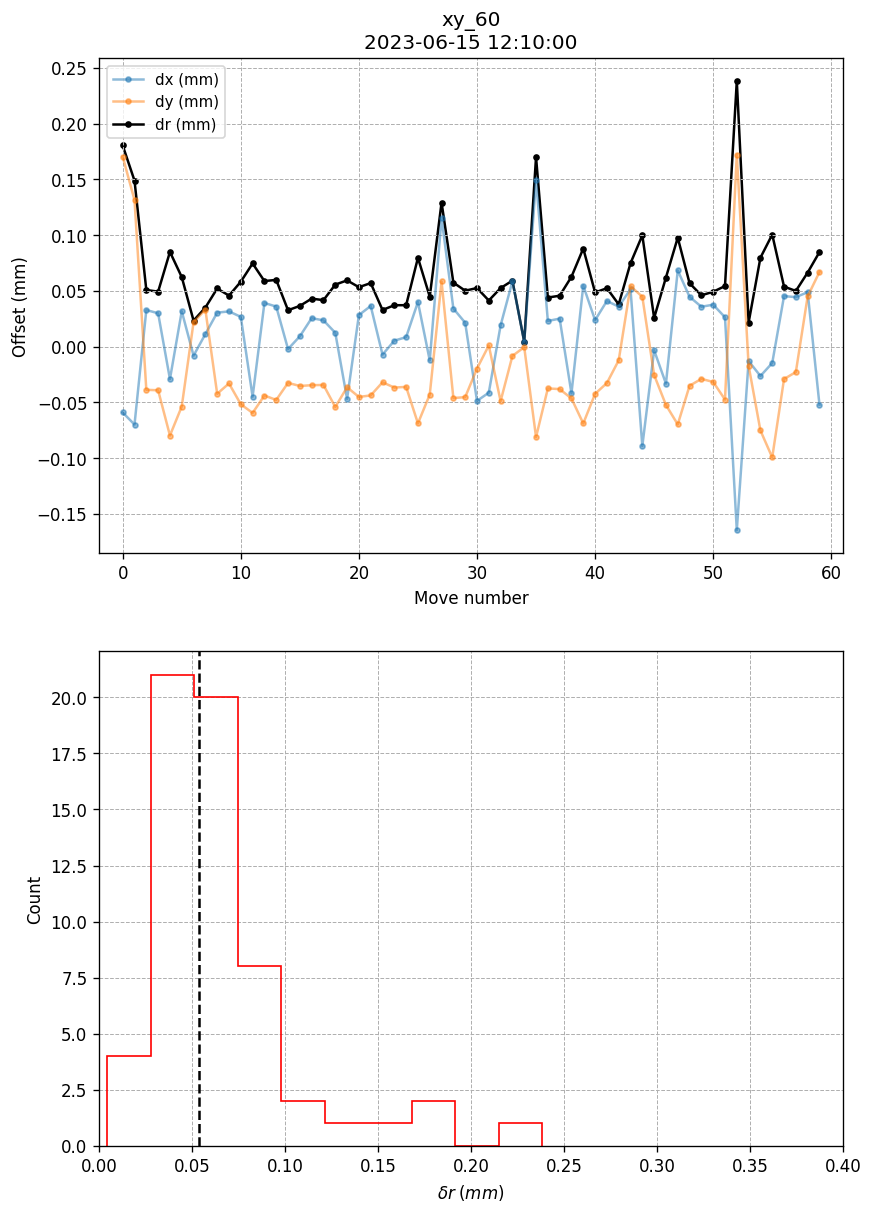

In [459]:
bump=1 # buffer on first subplot spacing

fig,ax = plt.subplots(2,1,figsize=[8,12])

dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
ax[0].plot(dx, '.-', label='dx (mm)', alpha=0.5)
ax[0].plot(dy, '.-', label='dy (mm)', alpha=0.5)
ax[0].plot(dr, 'k.-', label='dr (mm)', zorder=0)
ax[0].set_xlabel("Move number")
ax[0].set_ylabel("Offset (mm)")
ax[0].grid(lw=0.6, ls='--')
ax[0].set_xlim([-1-bump,len(dx)+bump])
ax[0].legend(loc='best', fontsize=9)
# plt.show()
ax[0].set_title(label+"\n"+dateStart)


ax[1].hist(dr, histtype='step',color='red')
ax[1].set_xlabel('$\delta r \;(mm)$')
ax[1].set_xlim([0,0.4])
ax[1].set_ylabel('Count')
ax[1].axvline(np.median(dr),0,5,c='black',ls='--')
ax[1].grid(lw=0.6, ls='--')

if save:
    plt.savefig("/home/msdos/DESI-QA/output/figures/ParameterTest/Hist_"+label+"_"+dateStart+".jpg",dpi=180)

plt.show()

# Histogram masked by travel distance - individual zig-zag moves

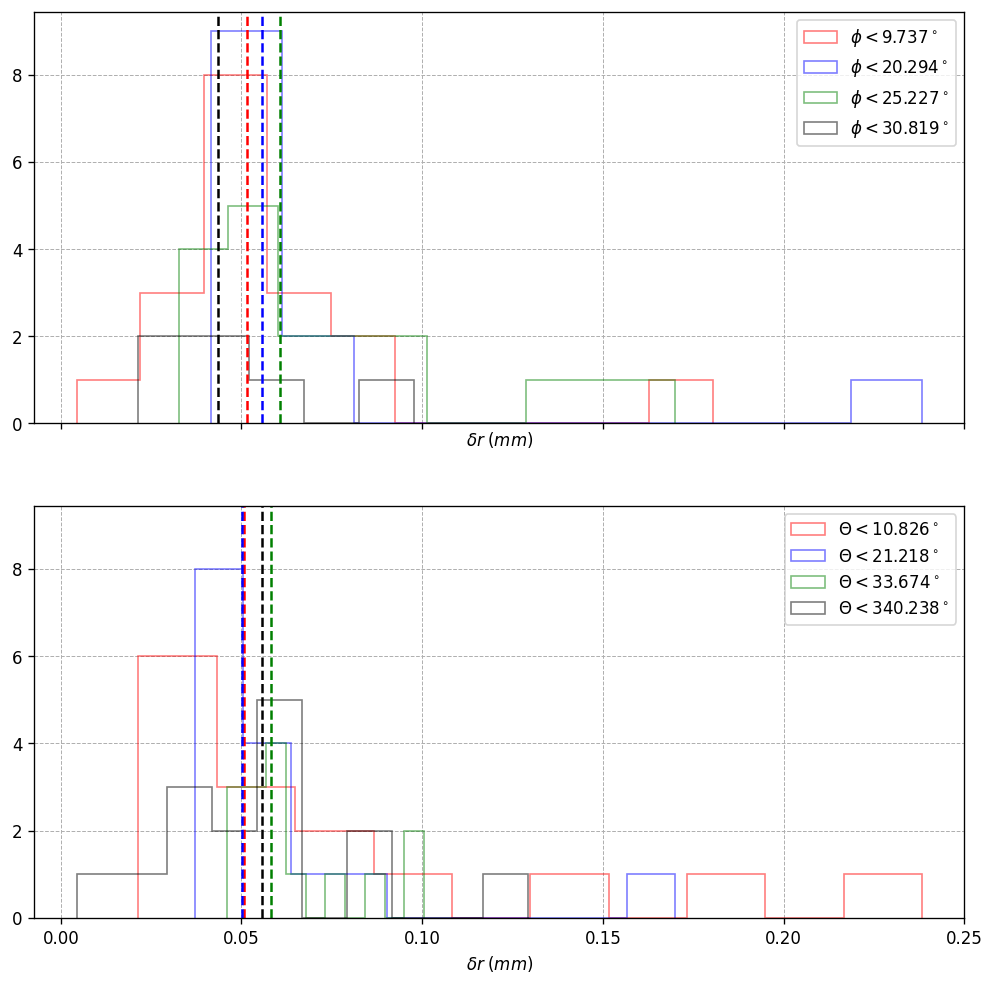

In [460]:
theta_arr,phi_arr = get_moveDirection(label,ABS=True)

# Creating plot
# fig, ax = plot_formatting()

phi_quantiles = np.array([])
theta_quantiles = np.array([])
colors = ['red','blue','green','black']

for j in range(4):
    phi_quantiles = np.append(phi_quantiles,np.quantile(phi_arr,0.25*(j+1)))
    theta_quantiles = np.append(theta_quantiles,np.quantile(theta_arr,0.25*(j+1)))

def set_flag(quantiles,values):
    ReturnArr = np.array([])
    for vals in values:
        if vals<=quantiles[0]:
            ReturnArr = np.append(ReturnArr,0)
        elif vals<=quantiles[1]:
            ReturnArr = np.append(ReturnArr,1)
        elif vals<=quantiles[2]:
            ReturnArr = np.append(ReturnArr,2)
        else:
            ReturnArr = np.append(ReturnArr,3)
    return ReturnArr
    
df = db[m2]
df.insert(4,"theta_quant",np.array(set_flag(theta_quantiles,theta_arr),dtype='int32'))
df.insert(4,"phi_quant",np.array(set_flag(phi_quantiles,phi_arr),dtype='int32'))
df.insert(4,"dr",dr)

fig,axs = plt.subplots(2,1,figsize=[10,10],sharex=True,sharey=True)

for j in range(4):
    del_r = df[df['phi_quant']==j]['dr']
    axs[0].hist(del_r,histtype='step',label=f"$\phi <{phi_quantiles[j]:.3f} ^\circ$",alpha=0.5,color=colors[j])
    axs[0].legend()
    axs[0].axvline(np.median(del_r),0,5,c=colors[j],ls='--')
# axs[0].set_ylim([0,5])
axs[0].grid(lw=0.6, ls='--')
axs[0].set_xlabel('$\delta r \;(mm)$')
# plt.savefig("/home/msdos/DESI-QA/output/figures/Hist_masked_phi_"+label+".jpg",dpi=180)
# plt.show()

# fig,axs = plt.subplots(2,2,figsize=[10,10],sharex=True,sharey=True)

for j in range(4):
    del_r = df[df['theta_quant']==j]['dr']
    axs[1].hist(del_r,histtype='step',label=f"$\Theta <{theta_quantiles[j]:.3f} ^\circ$",alpha=0.5,color=colors[j])
    axs[1].legend()
    axs[1].axvline(np.median(del_r),0,6,c=colors[j],ls='--')
# axs[1].set_ylim([0,6])
axs[1].grid(lw=0.6, ls='--')
axs[1].set_xlabel('$\delta r \;(mm)$')
plt.savefig("/home/msdos/DESI-QA/output/figures/ParameterTest/Hist_masked_theta_"+label+".jpg",dpi=180)

plt.show()
    
#     del_r = df[df['theta_quant']==j]['dr']
#     axs[1].hist(del_r,histtype='step',label=f"$\Theta <{theta_quantiles[j]:.3f} ^\circ$")
#     axs[1].legend()


# Histogram masked by travel distance - all zig-zag moves

['2023-05-30T11:48:35.000000000']
(60, 2)
['2023-05-30T14:44:10.000000000']
(60, 2)
['2023-05-30T15:12:27.000000000']
(60, 2)
['2023-05-30T12:05:06.000000000']
(60, 2)
['2023-05-30T16:01:33.000000000']
(60, 2)
['2023-05-30T16:17:25.000000000']
(60, 2)
['2023-05-30T16:32:10.000000000']
(60, 2)
['2023-05-30T18:26:07.000000000']
(60, 2)
Number of moves in phi < 10.0 degrees sample: 144
Number of moves in phi < 25.0 degrees sample: 128
Number of moves in phi < 37.5 degrees sample: 128
Number of moves in phi < 55.0 degrees sample: 80
Number of moves in theta < 18.75 degrees sample: 116
Number of moves in theta < 30.0 degrees sample: 124
Number of moves in theta < 60.0 degrees sample: 120
Number of moves in theta < 355.0 degrees sample: 120


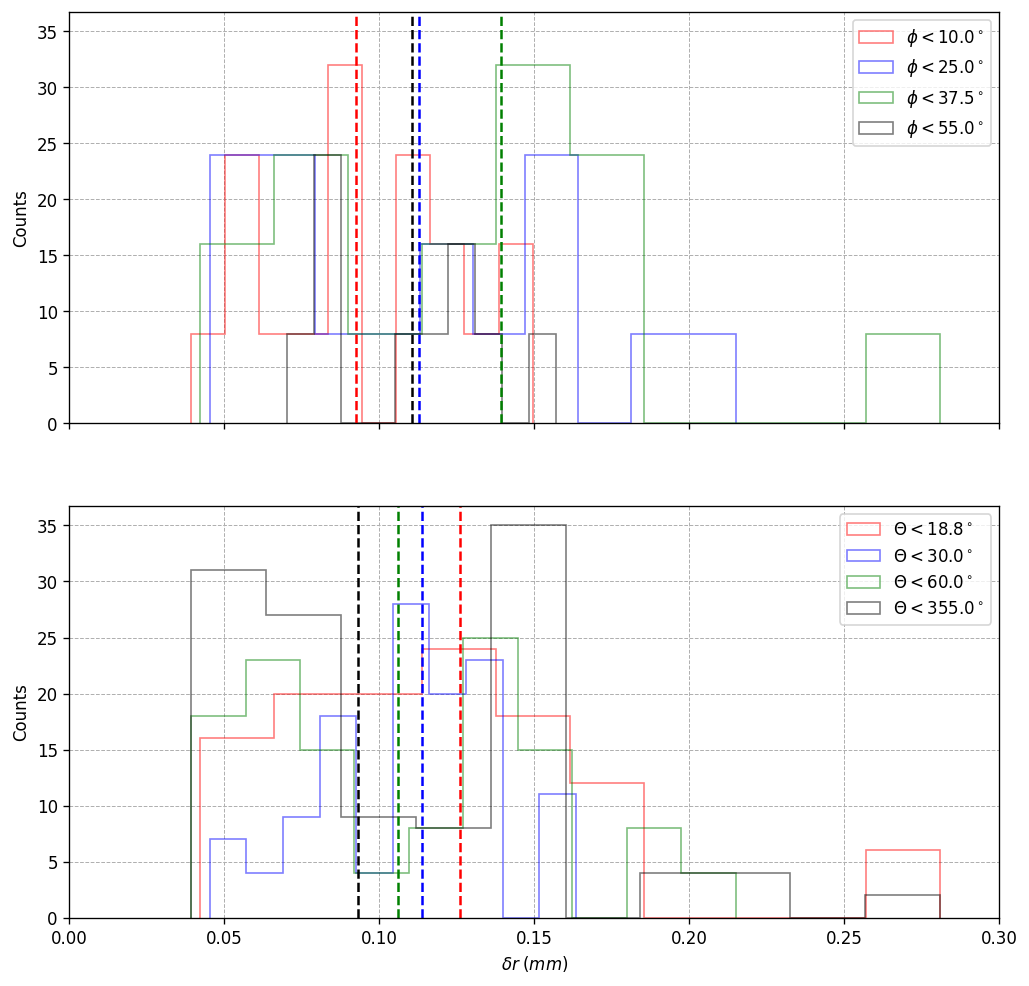

In [755]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

dateStartArr = np.array(['2023-05-30 11:48:00','2023-05-30 14:43:00','2023-05-30 15:12:00','2023-05-30 12:05:00','2023-05-30 16:01:00','2023-05-30 16:17:00','2023-05-30 16:31:00','2023-05-30 18:25:00'],dtype='datetime64')
dateEndArr = dateStartArr+np.timedelta64(5, 'm')
labelArr = np.array(['zig','zig_flipx','zig_flipy','zig_flipxy','zag','zag_flipx','zag_flipy','zag_flipxy'])

df = pd.DataFrame(data=None,columns=db.columns.values)

fig,axs = plt.subplots(2,1,figsize=[10,10],sharex=True,sharey=True)

phi_quantiles = np.array([10,25,37.5,55])
theta_quantiles = np.array([18.75,30,60,355])
colors_theta = ['red','blue','green','black']
colors_phi = ['red','blue','green','black']

theta_flags = np.array([],dtype='int32')
phi_flags = np.array([],dtype='int32')
dr_arr = np.array([],dtype='int32')

def set_flag(quantiles,values):
    ReturnArr = np.array([])
#         valmax = 0
    for vals in values:
        if vals<=quantiles[0]:
            ReturnArr = np.append(ReturnArr,0)
        elif vals<=quantiles[1]:
            ReturnArr = np.append(ReturnArr,1)
        elif vals<=quantiles[2]:
            ReturnArr = np.append(ReturnArr,2)
        else:
            ReturnArr = np.append(ReturnArr,3)
#             if valmax<vals:
#                 valmax = vals
#         print(valmax)
    return ReturnArr

theta_full_array = np.array([])
phi_full_array = np.array([])

for date in range(len(dateStartArr)):
    # Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
    dateStart = str(dateStartArr[date]) # This is the  time when you started your test
    label = 'xy_60_'+labelArr[date] # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future

    dateEnd = str(dateEndArr[date]) 

    get_timecol(db)

    m2 = query_time(db, datemin=dateStart)
    m2 = (m2) & ( db['label'].str.endswith(label) )
    get_dbxy(db, datemin=dateStart, datemax=dateEnd, label=label)

    xytgt = pd.read_csv("../movetables/"+label+".txt", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']
    
    ## Histogram plotting
    
    theta_arr,phi_arr = get_moveDirection(label,ABS=True)


    df = df.append(db[m2])
    theta_flags = np.append(theta_flags,np.array(set_flag(theta_quantiles,theta_arr),dtype='int32'))
    phi_flags = np.append(phi_flags,np.array(set_flag(phi_quantiles,phi_arr),dtype='int32'))
    dr_arr = np.append(dr_arr,dr)
    
    theta_full_array = np.append(theta_full_array,theta_arr)
    phi_full_array = np.append(phi_full_array,phi_arr)

    
    db = pd.read_csv("../output/database.csv") #l27 -> l28

df.insert(4,"theta_quant",theta_flags)
df.insert(4,"phi_quant",phi_flags)
df.insert(4,"dr",dr_arr)
df.insert(4,"theta_move",theta_full_array)
df.insert(4,"phi_move",phi_full_array)

for j in range(len(phi_quantiles)):
    del_r = df[df['phi_quant']==j]['dr']
    print("Number of moves in phi < "+str(phi_quantiles[j])+' degrees sample: '+str(len(del_r)))
    axs[0].hist(del_r,histtype='step',label=f"$\phi <{phi_quantiles[j]:.1f} ^\circ$",alpha=0.5,color=colors_phi[j])
    axs[0].legend()
    axs[0].axvline(np.median(del_r),0,5,c=colors_phi[j],ls='--')

for j in range(len(theta_quantiles)):
    del_r = df[df['theta_quant']==j]['dr']
    print("Number of moves in theta < "+str(theta_quantiles[j])+' degrees sample: '+str(len(del_r)))
    axs[1].hist(del_r,histtype='step',label=f"$\Theta <{theta_quantiles[j]:.1f} ^\circ$",alpha=0.5,color=colors_theta[j])
    axs[1].legend()
    axs[1].axvline(np.median(del_r),0,6,c=colors_theta[j],ls='--')

axs[0].grid(lw=0.6, ls='--')
axs[0].set_ylabel('Counts')
axs[0].set_xlim([0,0.3])
axs[1].grid(lw=0.6, ls='--')
axs[1].set_xlabel('$\delta r \;(mm)$')
axs[1].set_ylabel('Counts')

plt.savefig("/home/msdos/DESI-QA/output/figures/Hist_masked_both_allzigs.jpg",dpi=180)

plt.show()

# STATISTICS! - incomplete

In [11]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

# All of these values can be found in Report-Copy1.ipynb - maybe figure a way to pass these values as a dictionary or something?
pix2mm = 0.03536752443853155 # last updated may 22
xc, yc = [69.96433, 31.51567]
R1 = 2.9467126
R2 = 3.0691875
rPositioner = R1+R2
hardstopAngle = 163.01813

dateStartArr = np.array(['2023-05-30 11:48:00','2023-05-30 14:43:00','2023-05-30 15:12:00','2023-05-30 12:05:00','2023-05-30 16:01:00','2023-05-30 16:17:00','2023-05-30 16:31:00','2023-05-30 18:25:00'],dtype='datetime64')
dateEndArr = dateStartArr+np.timedelta64(5, 'm')
labelArr = np.array(['zig','zig_flipx','zig_flipy','zig_flipxy','zag','zag_flipx','zag_flipy','zag_flipxy'])

for j in range(len(labelArr)):
    # Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
    dateStart = str(dateStartArr[iteration]) # This is the  time when you started your test
    label = 'xy_60_'+labelArr[iteration] # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future
    dateEnd = str(dateEndArr[iteration]) # Left as placeholder, you will have to update this occasionally


# Verification of arcsequence moves

In [378]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

# All of these values can be found in Report-Copy1.ipynb - maybe figure a way to pass these values as a dictionary or something?
pix2mm = 0.03536752443853155 # last updated may 22
xc, yc = [69.93287, 31.49778]
xc_pix,yc_pix = np.array([xc,yc])/pix2mm
R1 = 2.9510995
R2 = 3.0712471
rPositioner = R1+R2
hardstopAngle = 163.15746

xc2,yc2 = [69.93287, 31.49778]
xc2_pix,yc2_pix = np.array([xc2,yc2])/pix2mm

dateStartArr = np.array(['2023-06-14 19:41:00'],dtype='datetime64')
dateEndArr = dateStartArr+np.timedelta64(2, 'm')
labelArr = np.array(['arcph15'])

def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

centerArr = np.array([[xc2_pix,yc2_pix],[xc_pix,yc_pix]]) # IN PIXELS



for iteration in range(len(labelArr)):
    # Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
    dateStart = str(dateStartArr[iteration]) # This is the  time when you started your test
    label = labelArr[iteration] # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future
    dateEnd = str(dateEndArr[iteration]) # Left as placeholder, you will have to update this occasionally

    db.tail()

    get_timecol(db)

    m2 = query_time(db, datemin=dateStart)
    m2 = (m2) & ( db['label'].str.endswith(label) )
    get_dbxy(db, datemin=dateStart, datemax=dateEnd, label=label)

#     xytgt = pd.read_csv("../movetables/"+label+".txt", sep=" ", header=None)
#     xytgt.columns = ['direction', 'speed','motor','angle']
    
#     db.insert(0,'xpix_micron',pix2mm*(db[m2]['xpix'] - xc/pix2mm))
#     db.insert(0,'ypix_micron',pix2mm*(db[m2]['ypix'] - yc/pix2mm))
    
    print(label)
    
    for j in range(len(db[m2]['xpix'])-1):
        current = j+1
        old = j
        
        x_old = db[m2].reset_index()['xpix'][old]
        y_old = db[m2].reset_index()['ypix'][old]
        x_current = db[m2].reset_index()['xpix'][current]
        y_current = db[m2].reset_index()['ypix'][current]
        
        point_1 = np.array([x_old,y_old])
        point_2 = np.array([x_current,y_current])
        
        print((angle_between(centerArr[iteration],point_1,point_2)-30)/2)
        
    if iteration==0:
        db = pd.read_csv("../output/database.csv") #l27 -> l28


['2023-06-14T19:41:37.000000000']
(21, 2)
arcph15
-7.035675095810091
-3.9729725519425365
6.623072685365301
9.168495540661947
-4.4585744764260316
-9.820174799480636
-10.878967537515395
-12.082397845604577
-12.841177673870666
-12.377160967640238
-13.688516434821985
-13.302258981868626
-12.845695079716698
-12.325851843289056
-11.170861413743816
-9.470594868368945
-4.853549142025024
7.9098369502816475
9.740182462909772
-3.927731497763302


,label,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
2128,curreposition-20230613-193730,0.0,0.0,20230613-193732,4852,cw,cruise,theta,0.0,1811.086064,931.227773,0,80531.7151,4.0194
2129,curreposition-20230613-193800,0.0,0.0,20230613-193803,4852,cw,cruise,theta,0.0,1861.486228,765.180385,0,78484.7951,3.6624


# Verification of moves for zig-zag and grid tests

In [377]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

# All of these values can be found in Report-Copy1.ipynb - maybe figure a way to pass these values as a dictionary or something?
pix2mm = 0.03536752443853155 # last updated may 22
xc, yc = [69.96433, 31.51567]
xc_pix,yc_pix = np.array([xc,yc])/pix2mm
R1 = 2*2.9467126
R2 = 2*3.0691875
rPositioner = R1+R2
hardstopAngle = 163.01813

xc2,yc2 = [67.06089808643988, 32.38366935242969]
xc2_pix,yc2_pix = np.array([xc2,yc2])/pix2mm

dateStartArr = np.array(['2023-06-14 19:41:00'],dtype='datetime64')
dateEndArr = dateStartArr+np.timedelta64(2, 'm')
labelArr = np.array(['arcph15'])

def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

centerArr = np.array([[xc2_pix,yc2_pix],[xc_pix,yc_pix]]) # IN PIXELS



for iteration in range(len(labelArr)):
    # Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
    dateStart = str(dateStartArr[iteration]) # This is the  time when you started your test
    label = labelArr[iteration] # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future
    dateEnd = str(dateEndArr[iteration]) # Left as placeholder, you will have to update this occasionally

    db.tail()

    get_timecol(db)

    m2 = query_time(db, datemin=dateStart)
    m2 = (m2) & ( db['label'].str.endswith(label) )
    get_dbxy(db, datemin=dateStart, datemax=dateEnd, label=label)

    xytgt = pd.read_csv("../movetables/"+label+".txt", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']
    
    db.insert(0,'xpix_micron',pix2mm*(db[m2]['xpix'] - xc/pix2mm))
    db.insert(0,'ypix_micron',pix2mm*(db[m2]['ypix'] - yc/pix2mm))
    
    print(label)
    
    for j in range(len(db[m2]['xpix'])-1):
        current = j+1
        old = j
        
        x_old = xytgt['xpos'][old]
        y_old = xytgt['ypos'][old]
        x_current = xytgt['xpos'][current]
        y_current = xytgt['ypos'][current]
        
        point_1 = np.array([x_old,y_old])
        point_2 = np.array([x_current,y_current])
        print("Move from position "+str(old)+" to position "+str(current)+" is a total move of "+str(cm(hardstopAngle,R1,R2,point_1[0],point_1[1],point_2[0],point_2[1])))
        
#         print(xytgt['xpos'][0],xytgt['ypos'][1],point_2[0],point_2[1])
#         print(angle_between(centerArr[iteration],point_1,point_2))
    print('\n')
    if iteration==0:
        db = pd.read_csv("../output/database.csv") #l27 -> l28


['2023-06-14T19:41:37.000000000']
(21, 2)


ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [37]:
df[df['dr']<0.011]

,label,session,mtang1,mtang2,dr,phi_quant,theta_quant,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
1551,xy_60,2023-06-01 19:04:40,0.0,0.0,0.009834,2,2,20230601-191740,4852,ccw,cruise,phi,16.561247,2100.06148,838.977451,1,79121.6678,3.4882


# 3 by 3 figure

Figure that shows on one row: quiver plot, masked histogram, and statistics
Each row corresponds to a different configuration

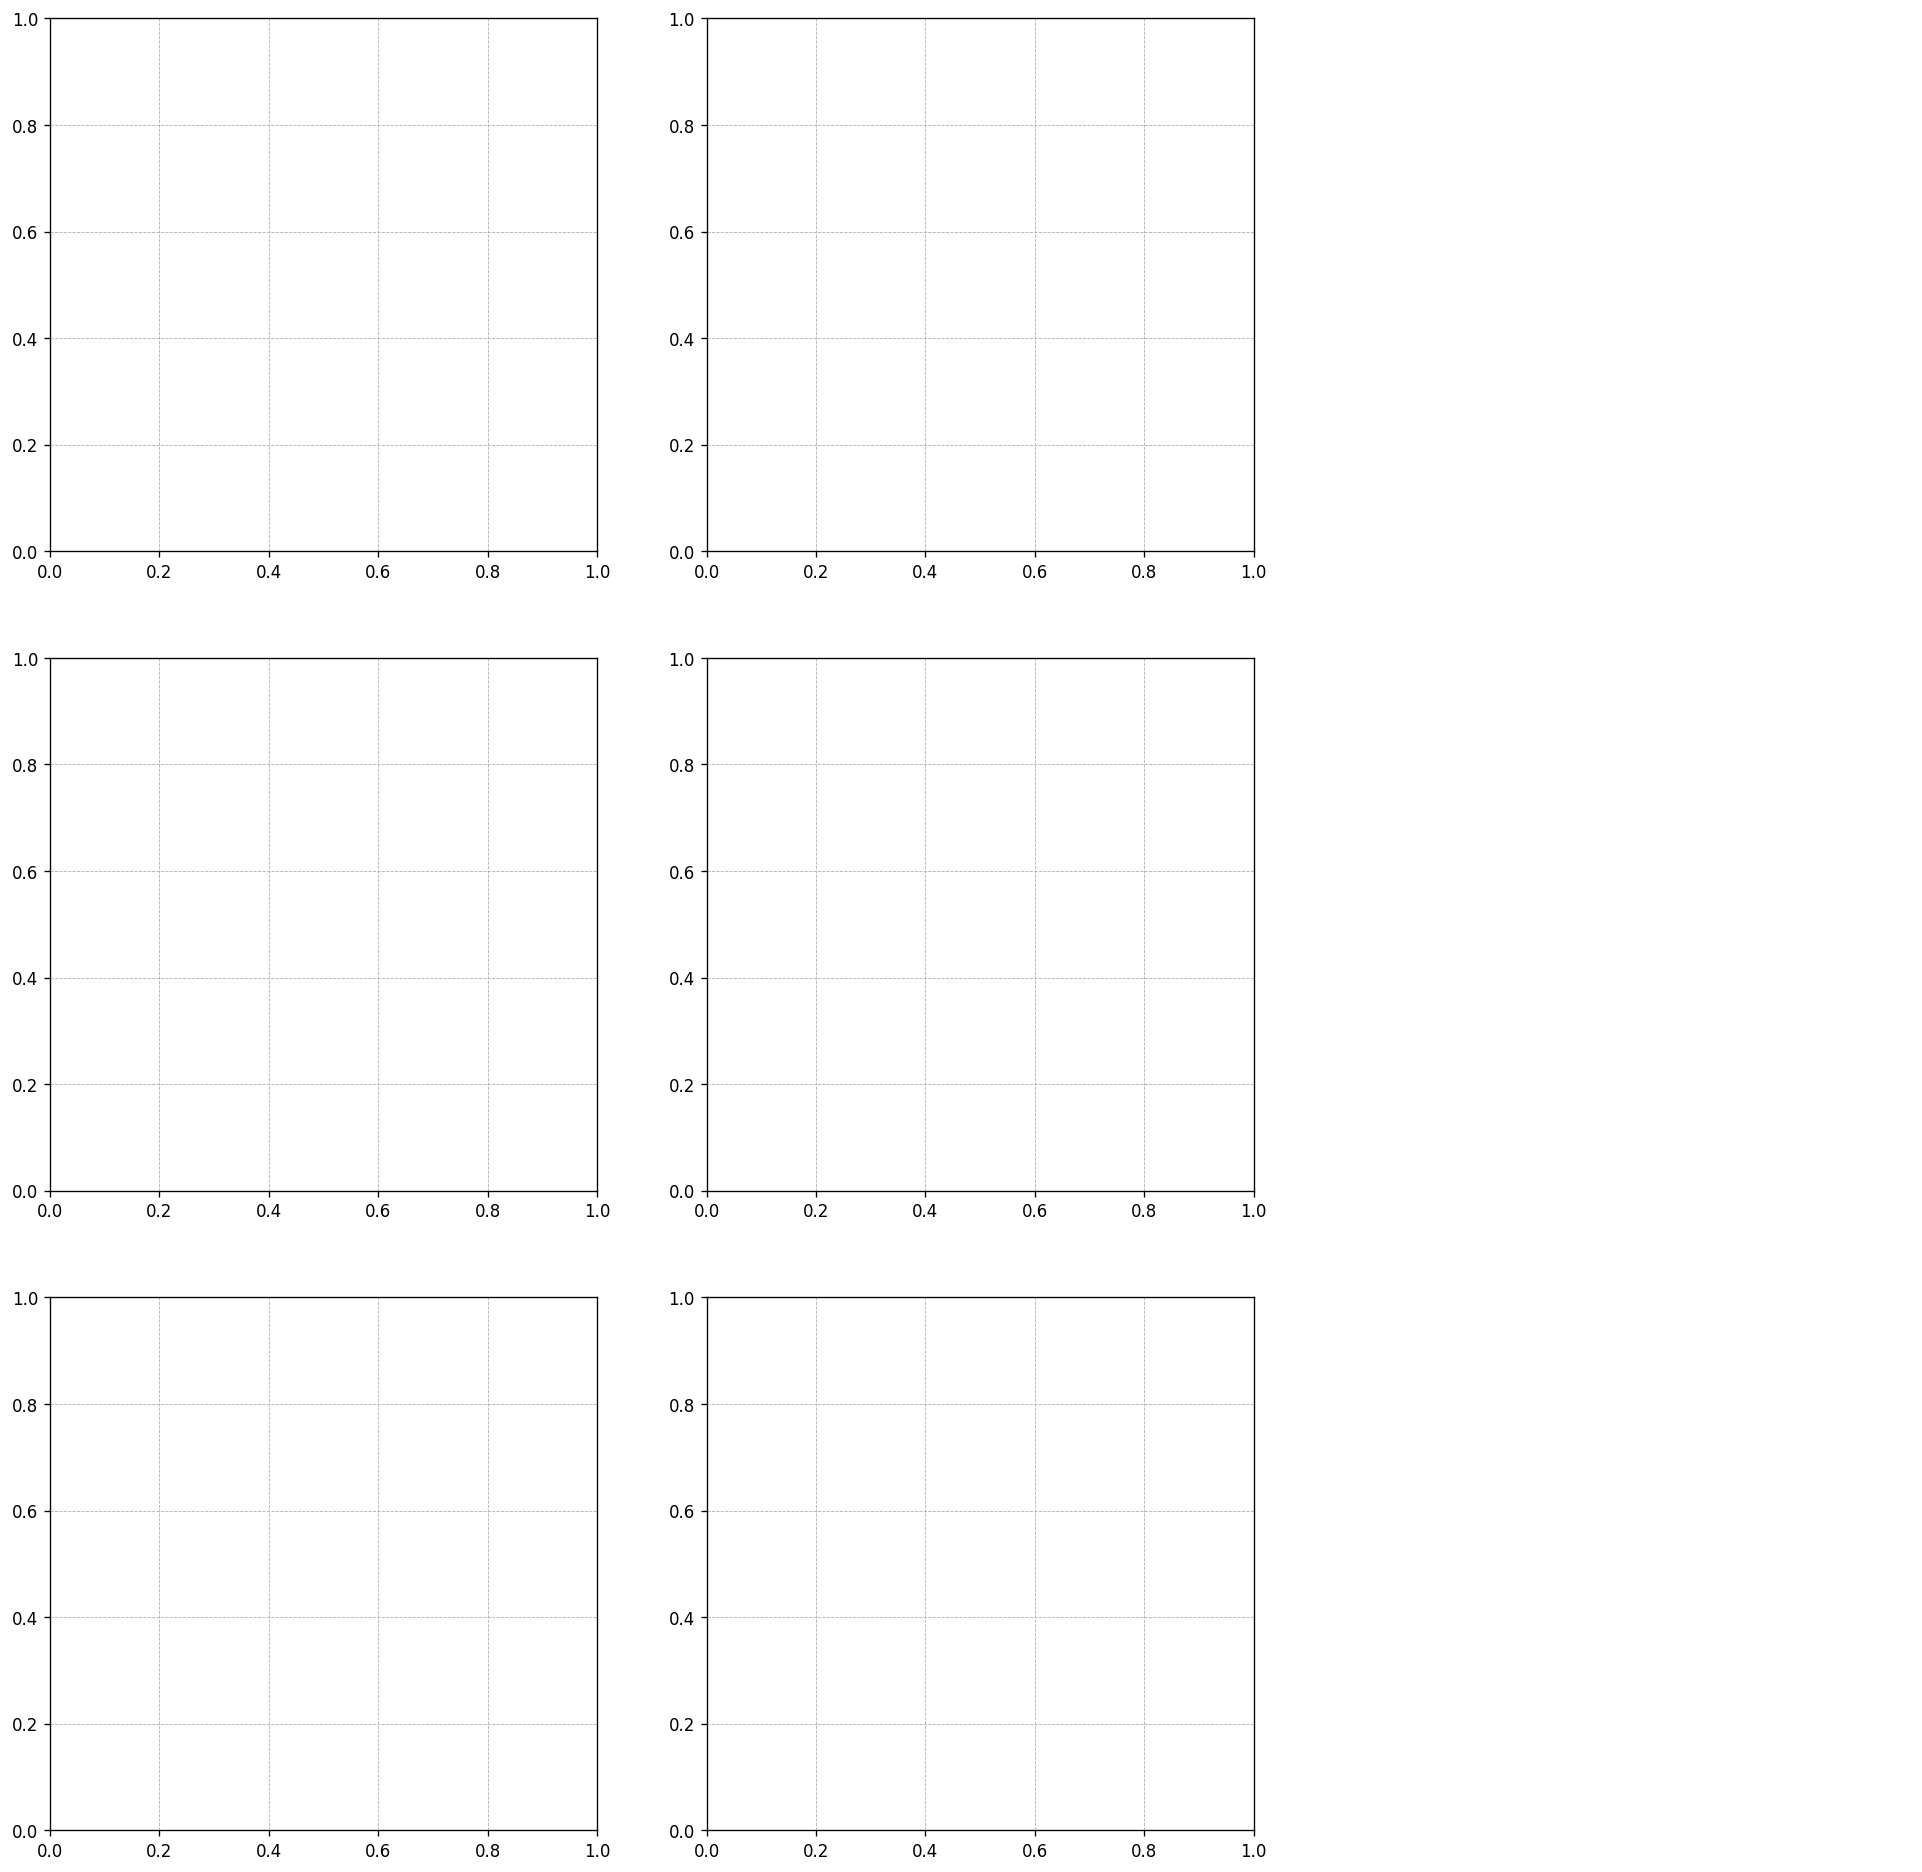

In [491]:
nrows = 3
ncols = 3





# Dates are packaged in sets of 3
# First set of three is default speed settings
# ADD OTHERS HERE
# Order of sets of dates is {arcth30 sequence, arcph15 sequence, xy_60 sequence}
positioner_horizon_dateStart = np.array(['2023-06-14 12:19:00','2023-06-14 12:30:00','2023-06-14 12:45:00'],dtype='datetime64')
positioner_up_dateStart = np.array(['2023-06-14 16:30:00','2023-06-14 16:34:00','2023-06-14 16:42:00'], dtype='datetime64')
positioner_down_dateStart = np.array(['2023-06-15 12:27:00','2023-06-15 12:05:00','2023-06-15 12:10:00'], dtype='datetime64')

position_Start = np.array([positioner_horizon_dateStart,positioner_up_dateStart,positioner_down_dateStart],dtype='datetime64')

positioner_horizon_dateEnd = positioner_horizon_dateStart + np.timedelta64(4,'m')
positioner_up_dateEnd = positioner_up_dateStart + np.timedelta64(4,'m')
positioner_down_dateEnd = positioner_down_dateStart + np.timedelta64(4,'m')

position_End = np.array([positioner_horizon_dateEnd,positioner_up_dateEnd,positioner_down_dateEnd],dtype='datetime64')

for speedIter in range(int(len(positioner_horizon_dateStart)//3)):
    
    fig,axs = plt.subplots(ncols,nrows,figsize=[20,20])
    
    # plot styling
    for j in range(nrows):
        axs[j][0].grid(linestyle='--',linewidth=0.5)
        axs[j][1].grid(linestyle='--',linewidth=0.5)
        axs[j][2].axis('off')
    
    for mountIter in range(nrows):
        
        # computations for finding centers
        
        db = pd.read_csv("../output/database.csv")
        get_timecol(db)
        
        thetaStart = position_Start[mountIter][3*speedIter+0]
        thetaEnd = position_End[mountIter][3*speedIter+0]
        
        phiStart = position_Start[mountIter][3*speedIter+1]
        phiEnd = position_End[mountIter][3*speedIter+1]
        
        testStart = position_Start[mountIter][3*speedIter+2]
        testEnd = position_End[mountIter][3*speedIter+2]
        
        m1 =  query_time(db, datemin=thetaStart,datemax=thetaEnd)
        m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')

        m2 = query_time(db, datemin=phiStart,datemax=phiEnd)
        m2 = (m2) & ( db['label'].str.contains('arcph') )
        
#         for figIter in range(ncols):
#             if mountIter==0:
#                 # Quiver
#             elif mountIter==1:
#                 # histogram
#             elif mountIter==2:
#                 # Stats
    
    plt.show()

In [366]:
for i in range(1):
    print(i)

0


## Redundant figures that were once useful

In [ ]:
xytgt = pd.read_csv("../movetables/XY_12.txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data = get_dbxy(db, datemin='2023-05-24 15:30:00', datemax='2024-01-01', label='xy12'),  
            marker='x')
plt.scatter('xpos', 'ypos', data = xytgt, marker='.')
plt.gca().set_aspect('equal')